# Advanced Lane Finding Project

[--> Rubric Points](https://review.udacity.com/#!/rubrics/571/view) 

---
<span style='color:blue'>**NOTE TO REVIEWER 1**</span>

<span style='color:blue'>I tuned a few parameters to get better results for different situations</span>

* In `ImageFilter.gradient_filter()` I changed sx_thresh from (20, 100) to (15, 250) 
* In `ImageFilter.gradient_filter()` I changed s_thresh from (170, 255) to (120, 255)
* In `LaneDetector.__init__()` I changed 
```
self.window_height      = 120 
self.window_width       = 8 
self.margin             = 10 
```

The pipeline works much better now, especially when a lot of light is present.

---

<span style='color:blue'>**NOTE TO REVIEWER 2**</span>

<span style='color:blue'>I implemented an additional mechanism for more robust detection. For each detection of a lane segment, I calculate a confidence value based on the sum of pixels inside the search window. 

```python
l_confidence = np.sum(conv_signal[l_min_index:l_max_index]/np.sum(conv_signal))
r_confidence = np.sum(conv_signal[r_min_index:r_max_index]/np.sum(conv_signal))
```

In order to get values between 0 and 1, I normalized the signal. During fitting I then remove lane detections with confidence lower or equal than 0.1 (see `LaneLine.idx_reject_outliers()`)

Also, I changed the birdseye warping so that the resulting image has more pixels in the x-direction.

Additionally, I removed areas of the transformed images where no lane are expected by drawing a black triangle on the warped image (see `LaneDetector.mask_image()`.

The pipeline gives much better results now.

---

The code is structured in four classes:
* `Camera` handling image distortion correction and warping
* `ImageFilter` including different gradient filter
* `LaneDetector` including the lane search pipeline
* `LaneLine` representing a single lane line

All Classes can be found in the "lib" subdirectory.

In [1]:
import cv2
import numpy as np
import lib
from lib.camera import Camera
from lib.image_filter import ImageFilter
from lib.lane_detector import LaneDetector
from lib.lane_line import LaneLine
from matplotlib import gridspec
import matplotlib.pyplot as plt
import importlib
importlib.reload(lib.camera)
importlib.reload(lib.image_filter)
importlib.reload(lib.lane_detector)
importlib.reload(lib.lane_line)
%matplotlib inline
print("libs imported")

libs imported


## 1. Camera Calibration

I wrote a class named `Camera` that handles all relevant task regarding camera calibration, correction, and warping. The code for the class `Camera` is contained in `lib/camera.py`.

In the calibration method `Camera.calibrate`, I use the given chessboard images to calibrate the camera. I start by preparing 9x6 "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  
I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function, which returns the following values:

| variable   | description |
|:----------:|:-----------:|
| `mtx`      |  3x3 floating-point camera matrix $A = \begin{pmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{pmatrix}$          |
| `imgpoints`|  image Points|
| `objpoints`|  object Points|
| `dist`     |  distortion coefficients ($k_1$, $k_2$, $p_1$, $p_2$, $k_3$)|
| `rvecs`    |  vector of rotation vectors |
| `tvecs`    |  vector of translation vectors|
| `ret`      |   root mean square (RMS) re-projection error ???|

Additional I wrote two methods to save and load calibration data. In order to load calibration data I use `Camera.load_calibration()`.
Applying this distortion correction to a test image (using the `cv2.undistort()` function), I obtain this result:

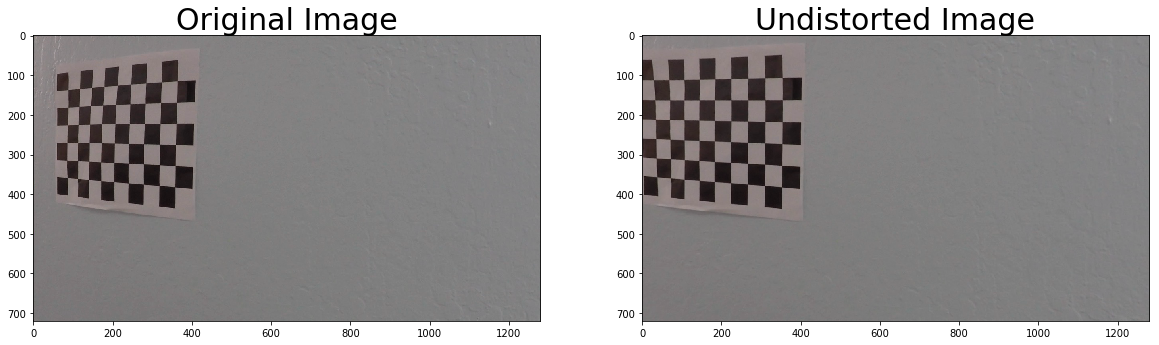

In [2]:
cam = Camera()
cam.load_calibration()

# Undistort image using camera matrix
img = cv2.imread('camera_cal/calibration19.jpg')
dst = cam.undistort_img(img);

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img), ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst), ax2.set_title('Undistorted Image', fontsize=30);

# 2. Pipeline (single images)

In the following sections, I will explain the lane detection pipeline.

## Step 1: Camera correction

First, the image is corrected using the existing `Camera`-class. This gives the following result:

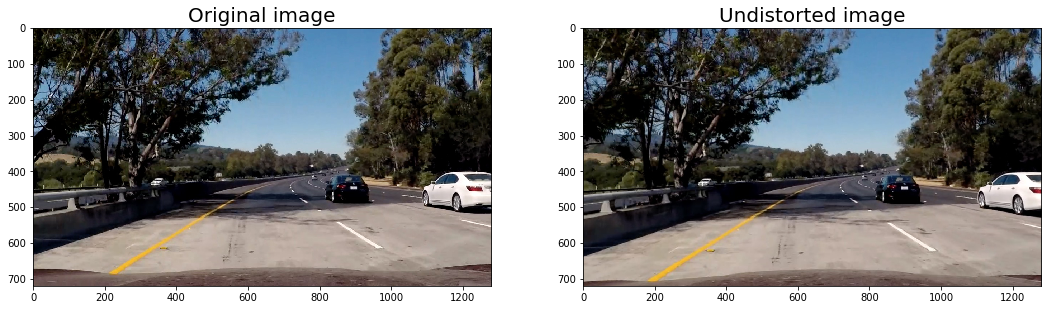

In [3]:
# Load and filter image
img = cv2.imread('test_images/color-shadow-example.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Instatiate camera, load calibration data and undistort
cam = Camera()
cam.load_calibration()
img_undist = cam.undistort_img(img);

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,9))
ax1.imshow(img), ax1.set_title('Original image', fontsize=20)
ax2.imshow(img_undist), ax2.set_title('Undistorted image', fontsize=20);
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## Step 2: Lane pixel detection

After successfully correcting for camera distortions lane lines candidates pixels are marked using two methods:

1. After converting the image from RGB to HLS color space a threshold detection is used on the S-channel. I detect values between 170 and 255. This detects bright pixels independent of the color.
2. A gradient detection is applied on the L-Channel of the converted image. I used a Sobel filter in the x-direction and a threshold between 20 and 100. The Sobel filter detect edges by calculating gradients.

Results are shown in blue (S-channel threshold) and green (Sobel-X) respectively. It can be seen, that lane lines are detected even in presence of shadow and light.

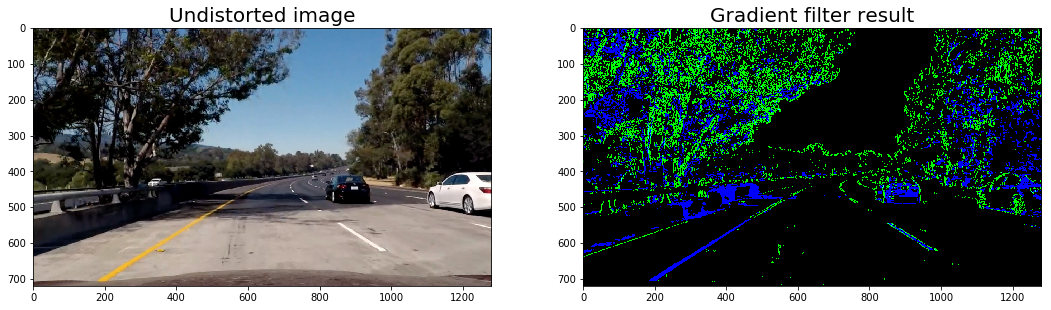

In [4]:
# Load and filter image
color_binary, result = ImageFilter.gradient_filter(img_undist, s_thresh=(170, 255), sx_thresh=(20, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
ax1.imshow(img_undist);  ax1.set_title('Undistorted image', fontsize=20)
ax2.imshow(color_binary); ax2.set_title('Gradient filter result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.show()

## Step 3: Perspective transformation

For the perspective transformation, I used `cv2.warpPerspective`. In order to warp an image, a transformation matrix is required. This matrix can be calculated using `cv2.getPerspectiveTransform` for given source and destination points. The code can be found in `Camera.warp_birdeye`.

As source points, I marked for points in `straight_lines1.jpg`. On the right side, I put a marker after a long dash, which allows me to relate the pixel measurement to a real world measurement of distance later. The source points end up beeing:

```
133         src = [[308,648],[1000,648],[579,460],[703,460]]
```

Based on my research I found that typical lane width in California, USA is 3.7m or 12ft. Also, I found that "each dashed line measures 10 feet, and the empty spaces in-between measure 30 feet". This lead me to the definition of the real world distances between my marker source points:

```
129         Lane_W = factor_x*(12)          # ft (lane width)
130         Lane_D = factor_y*(30+10+30+10) # ft (lane distance)
```

A factor of 5 is used in x-direction and a factor of 50 is used in y-direction to transfer real-world distances to pixels distances again. This gives me the new image coordinates of the warped image.

```
140         dst = np.float32([[offset_x,        img_size[1]+offset_y],
141                           [Lane_W+offset_x, img_size[1]+offset_y],
142                           [offset_x,        img_size[1]-Lane_D+offset_y],
143                           [Lane_W+offset_x, img_size[1]-Lane_D+offset_y]])
```

The offsets are defined as follows. An additional half lane width is used on the left and right side respectively before cropping the image.

```
140             offset_x = int(Lane_W/2);
141             offset_y = -5;
142             cut_x    = 2*offset_x + Lane_W;
```

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image. To check for parallelity an additional yellow line is given. My approach is a little bit different from the approach showed in class, as it tries to calculate correct image proportions for the birdseye view. This is useful because pixel distances in the warped image can be converted to real world distances using a factor of 5 px/ft and 50 px/ft.

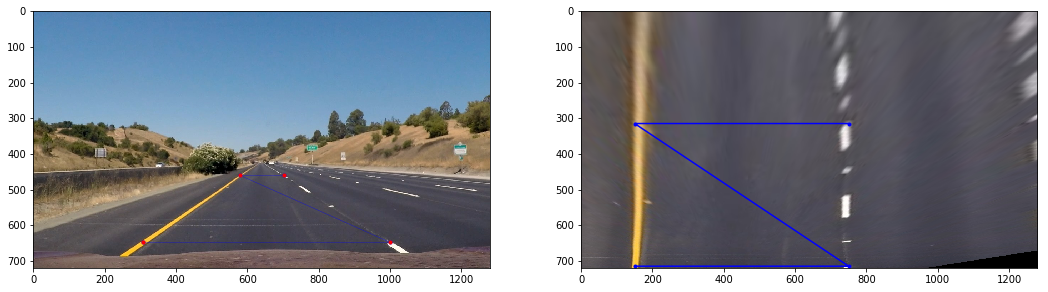

In [5]:
cam = Camera()
cam.load_calibration()

# Load image and warp
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_warp = cam.warp_birdeye(image)

fig = plt.figure(figsize=(18, 9)) 
#gs = gridspec.GridSpec(1, 2, width_ratios=[10.6, 1]) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
ax0.imshow(image)
ax0.plot(cam.src[:,0],cam.src[:,1],'b.-', linewidth=0.3)
for i in range(4): ax0.plot(cam.src[i,0],cam.src[i,1],'r.')

ax1 = plt.subplot(gs[1])
ax1.imshow(image_warp[0:,:,:])
ax1.plot(cam.dst[:,0],cam.dst[:,1],'b.-')
#ax1.plot([25,25],[0,715], 'y-')
plt.show()

## Step 4:  Lane detection and model fitting

The relevant method are `LandeDetector.find_window_centroids` and `LaneLine.fit_next`.

For the lane detection, I used the approach described in the lecture using a convolution signal and finding the maximum in the convoluted signal with little modifications. I used a windows width of 5 and a window height of 80. 
Additionally, I modified the code to include the y-positions of the detected lane segments in `window_centroids`.

In order to obtain a fitted model of the lane line, I tried different approaches that increase robustness. First I implemented a simple version of the [https://en.wikipedia.org/wiki/Random_sample_consensus RANSAC algorithm] but then decided to use a simple approach for outlier rejection. The method for outlier rejection can be found in `LaneLine.idx_reject_outliers`. First, the data is normalized [http://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list using the median] and then compared to `m` of 2.0. Also, lane segments very close to the left edge of the image are rejected. This gives good result while beeing computational less expensive than the RANSAC approach.

As shown in the following image, second order polynomials are fitted to the detected data:

![](http://localhost:8888/files/CarND-Advanced-Lane-Lines/output_images/color_fit_lines.jpg "Color Fit Lines")
Img. 1

In order to detect wrong detections over time, the lane coordinates are predicted for a distance of [50, 150, 250, 350, 450, 550] px using the newly detected coefficients and using the coefficients from the previous detection. If the RMSE is bigger then 10 the detection of the current frame is considered invalid.
In order to smooth the result over time, the coefficients are also filtered with an adaption rate of 0.05.

The result is shown in the following images:

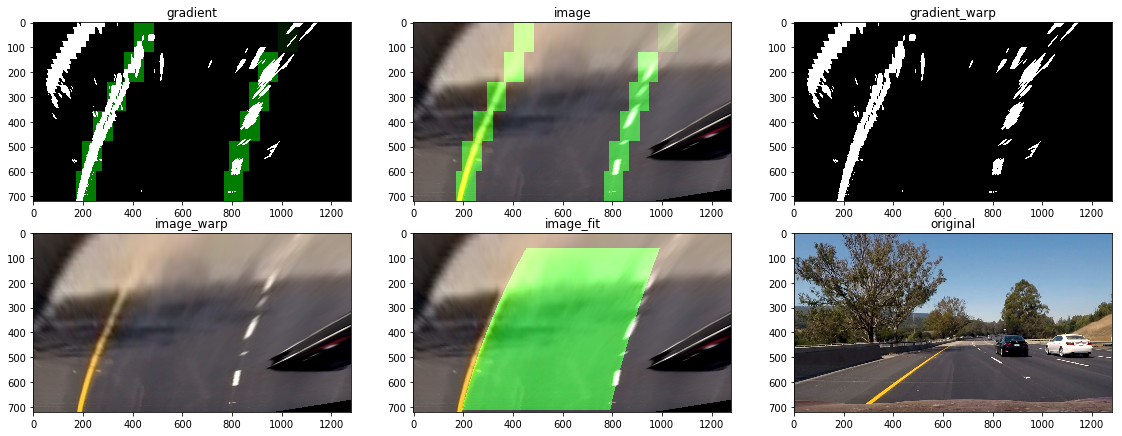

In [6]:
image = cv2.imread('test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run full pipeline
ld = LaneDetector()
images = ld.pipeline(cam, ImageFilter, image)

# Display the final results
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 6))
f.tight_layout()
ax1.imshow(images['gradient']);                  ax1.set_title('gradient')
ax2.imshow(images['image']);                     ax2.set_title('image')
ax3.imshow(images['gradient_warp'],cmap='gray'); ax3.set_title('gradient_warp')
ax4.imshow(images['image_warp']);                ax4.set_title('image_warp')
ax5.imshow(images['image_fit']);                 ax5.set_title('image_fit')
ax6.imshow(image);                               ax6.set_title('original')
plt.show()    

I also mask the transformed image like this (mask shown in red):

![alt](./output_images/mask.png)

## Step 5: Calulation radius of curvature and relative vehicle position

I implemented two methods. `LaneLine.get_radius` returns the radius of curvature of the lane.
`LaneLine.get_vehicle_offset` returns the position of the vehicle with respect to center.

Withe the previously described "pixel to feet"-factor and appropriate unit conversion pixels can be transformed to real world distances:

```
factor_x   = 5 # px/ft
factor_y   = 50 # px/ft
ft_to_m    = 0.3048 # m/ft
ym_per_pix = (1/factor) * ft_to_m # ft/px * m/ft => m/px
xm_per_pix = (1/factor) * ft_to_m # ft/px * m/ft => m/px
```

The curvature can then becalculated from:

```
((1 + (2*self.fit_cr[0]*y_eval*ym_per_pix + self.fit_cr[1])**2)**1.5)/ np.absolute(2*self.fit_cr[0])
```

It is calculated for both lanes and then averaged.
The lane offset from the lane center is calculated from

```
center_px = 450
lane_offset = (center_px - self.fit_cr[2])*xm_per_pix # TODO: Das ist feet
```

where center_px in the center of the road in the warped image. The value 59 was estimated based on an image where the car was driving in the center of the road and then calculating the mid point between the two road lines. The lane offset is calculated for each lane. The vehicle offset is then calculated from the sum of both lane offsets, whereas one lane offset is positive and one lane offset is negative.

## Final result

The full pipeline is given in `LaneDetector.pipeline`. It gives the following final result. Blue dots mark the dected lane segments, while the green area is calculated from the fitted polynomial model.

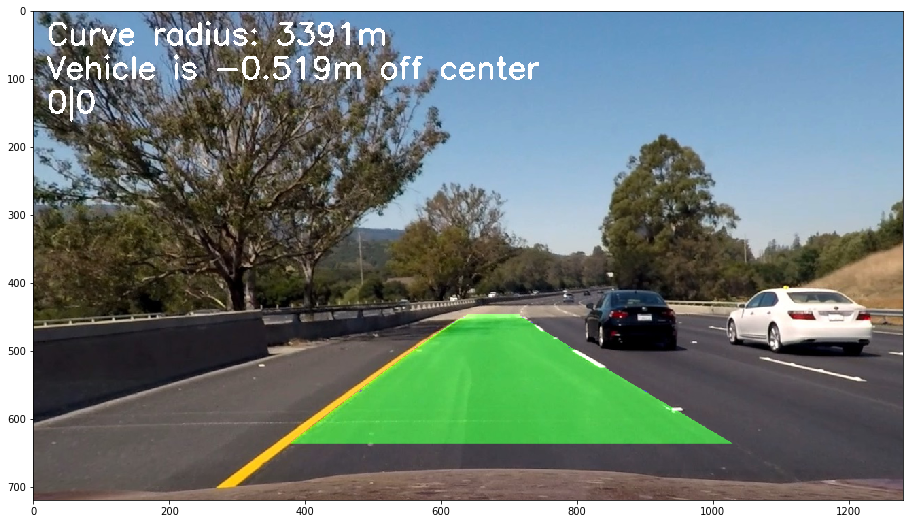

In [7]:
# Display the final results
plt.figure(figsize=(20, 9))
plt.imshow(images['final']);

# 3. Pipeline (video)

Final result on `project_video.mp4` looks like:

In [9]:
from IPython.display import HTML
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format('project_video_lane_detection.mp4?2'))

Alternative: [link to video result](./project_video_lane_detection.mp4)

# 4. Discussion

Although the algorithm performs well on the project video, It fails on the challenge video. It could be improved by further parameter tuning. Also, due to the birdseye transformation with correct image proportions, a lot of information in the x-direction is lost, which could be useful.

Currently, both lanes are detected independently. Since the road width mostly stays constant, this information can be used. An idea would be to calculate the confidence for both lane lines and if one confidence is lower than the other, the second lane is estimated from the lane with higher confidence.
Also, a confidence value could be used for better the adaptation rate over time.